In [140]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import copernicusmarine as cm
import matplotlib.pyplot as plt
import geoplot
import matplotlib as mpl
%matplotlib inline

In [ ]:
#monthly bottom temp data from copernicus
#ds_gl = cm.open_dataset(dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m")

In [ ]:
#bt_gl = ds_gl.bottomT.sel(latitude = slice(30, 48), longitude = slice(-80, -60))

In [ ]:
#bt_gl.to_netcdf('bt_glorys_M.nc')

In [ ]:
#opendap_url = "http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/hist_run/regrid/ocean_monthly.199301-201912.tob.nc"
#bt_m6 = xr.open_dataset(opendap_url)

In [ ]:
#bt_m6 = xr.open_dataset('ocean_monthly.199301-201912.tob.nc')

In [ ]:
#bt_mom6 = bt_m6.sel(lat = slice(30,48), lon = slice(260,300))

In [ ]:
#bt_mom6.to_netcdf('bt_mom6_M.nc')

In [2]:
bt_gl = xr.open_dataset('bt_glorys_M.nc')
bt_m6 = xr.open_dataset('bt_mom6_M.nc')

In [ ]:
# dont need to do this for mean bt across each strata
gl_regrid = np.empty([324, 774, 844])
#gl_lons = np.concatenate((np.array(bt_glorys.longitude[:2161]+360), np.array(bt_glorys.longitude[2161:])))
LAT, LON = np.meshgrid(bt_mom6.lat.values, bt_mom6.lon.values-360)
for i in range(324):
    interp_to_mom6 = RegularGridInterpolator((bt_glorys.latitude.values, bt_glorys.longitude.values), bt_glorys.bottomT[i,:,:].values, bounds_error = False, fill_value = np.nan)
    gl_regrid[i,:,:] = interp_to_mom6((LAT, LON))

In [3]:
strata = gpd.read_file('EcoMon_strata/EcoMon_Strata.shp')

In [85]:
# Get the region of interest
region = regionmask.from_geopandas(strata)

In [117]:
# Create the mask
mask = region.mask(bt_gl.longitude, bt_gl.latitude)

In [118]:
mask2 = region.mask(bt_m6.lon.astype('f4'), bt_m6.lat.astype('f4'))#, wrap_lon = False)

In [6]:
bt_gl_strata = xr.Dataset(data_vars = {'01': (['time','latitude','longitude'], bt_gl.bottomT.where(mask == region.numbers[0]).data)},
                          coords = {'time': bt_gl.time,
                                    'latitude': bt_gl.latitude,
                                    'longitude': bt_gl.longitude})

In [7]:
for i in np.arange(1, len(region.numbers)):
    masked_ds = bt_gl.where(mask == region.numbers[i])
    strata_bt_gl_n = xr.Dataset(data_vars = {strata.STRATA[i]: (['time','latitude','longitude'], bt_gl.bottomT.where(mask == region.numbers[i]).data)},
                          coords = {'time': bt_gl.time,
                                    'latitude': bt_gl.latitude,
                                    'longitude': bt_gl.longitude})
    bt_gl_strata = xr.merge([bt_gl_strata, strata_bt_gl_n])

In [120]:
bt_m6_strata = xr.Dataset(data_vars = {'01': (['time','latitude','longitude'], bt_m6.tob.where(mask2 == region.numbers[0]).data)},
                          coords = {'time': bt_m6.time,
                                    'latitude': bt_m6.lat.values,
                                    'longitude': bt_m6.lon.values})

In [121]:
for i in np.arange(1, len(region.numbers)):
    masked_ds = bt_m6.where(mask2 == region.numbers[i])
    strata_bt_m6_n = xr.Dataset(data_vars = {strata.STRATA[i]: (['time','latitude','longitude'], bt_m6.tob.where(mask2 == region.numbers[i]).data)},
                          coords = {'time': bt_m6.time,
                                    'latitude': bt_m6.lat.values,
                                    'longitude': bt_m6.lon.values})
    bt_m6_strata = xr.merge([bt_m6_strata, strata_bt_m6_n])

In [126]:
bt_gl_strata[strata.STRATA[0]].mean()

<xarray.DataArray '01' ()>
array(11.000898, dtype=float32)

In [150]:
bias_seasons = bt_m6_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time']) - bt_gl_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time'])


In [151]:
bias_seasons

<xarray.DataArray '01' (season: 4)>
array([ 0.14507389,  0.2989025 ,  0.79251957, -0.26698017], dtype=float32)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [153]:
bias = bt_m6_strata[strata.STRATA[0]].mean() - bt_gl_strata[strata.STRATA[0]].mean()
bias_seasons = bt_m6_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time']) - bt_gl_strata[strata.STRATA[0]].groupby('time.season').mean(['latitude','longitude','time'])
bias_winter = bias_seasons[0]
bias_spring = bias_seasons[2]
bias_summer = bias_seasons[1]
bias_fall = bias_seasons[3]

#1 Bias
for i in np.arange(1, len(region.numbers)):
    bias_n = bt_m6_strata[strata.STRATA[i]].mean() - bt_gl_strata[strata.STRATA[i]].mean()
    bias_seasons_n = bt_m6_strata[strata.STRATA[i]].groupby('time.season').mean(['latitude','longitude','time']) - bt_gl_strata[strata.STRATA[i]].groupby('time.season').mean(['latitude','longitude','time'])
    bias_winter = np.append(bias_winter, bias_seasons_n[0])
    bias_spring = np.append(bias_spring, bias_seasons_n[2])
    bias_summer = np.append(bias_summer, bias_seasons_n[1])
    bias_fall = np.append(bias_fall, bias_seasons_n[3])
    bias = np.append(bias, bias_n)

In [136]:
strata['bias'] = bias
strata['bias_djf'] = bias_winter
strata['bias_mam'] = bias_spring
strata['bias_jja'] = bias_summer
strata['bias_son'] = bias_fall

In [137]:
strata

,STRATA,geometry,bias
0,01,"POLYGON ((-74.80749 35.76881, -74.80510 35.763...",0.250170
1,02,"POLYGON ((-75.21358 35.50122, -75.21112 35.504...",0.705049
2,03,"POLYGON ((-75.27774 35.14312, -75.27812 35.142...",-0.740721
3,04,"POLYGON ((-74.37205 37.45870, -74.37800 37.453...",0.092263
4,05,"POLYGON ((-74.63894 37.71186, -74.63976 37.710...",1.583154
5,06,"POLYGON ((-75.71381 37.50764, -75.71381 37.504...",-0.724605
6,07,"POLYGON ((-73.32678 38.45735, -73.33272 38.453...",0.656456
7,08,"POLYGON ((-74.44489 39.04869, -74.41609 39.033...",0.971866
8,09,"POLYGON ((-75.10498 37.82012, -75.10795 37.812...",-0.383771
9,10,"POLYGON ((-72.73364 39.16571, -72.70262 39.142...",-0.137446


<Axes: >

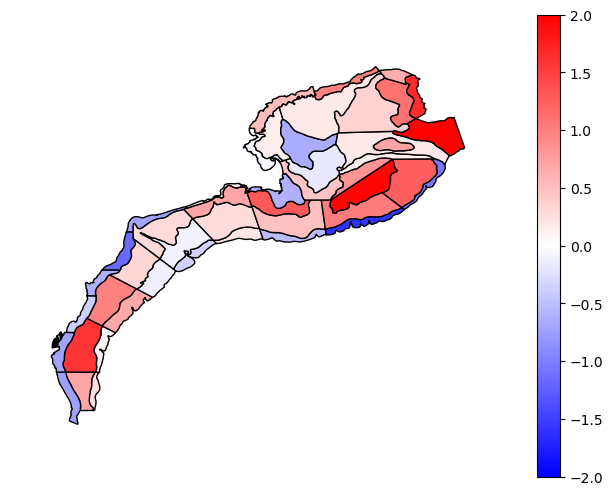

In [142]:
norm = mpl.colors.Normalize(vmin=-2.,vmax=2.)
geoplot.choropleth(df = strata, hue = 'bias',cmap = 'bwr', norm = norm, legend =True)

In [132]:
help(geoplot.choropleth)

Help on function choropleth in module geoplot.geoplot:

choropleth(df, projection=None, hue=None, cmap=None, norm=None, scheme=None, legend=False, legend_kwargs=None, legend_labels=None, legend_values=None, extent=None, figsize=(8, 6), ax=None, **kwargs)
    A color-mapped area plot.

    Parameters
    ----------

    df : GeoDataFrame
        The data being plotted.
    projection : geoplot.crs object instance, optional
        The projection to use. For reference see
        :ref:`/user_guide/Working_with_Projections.ipynb`.
    hue : None, Series, GeoSeries, iterable, or str, optional
        The column in the dataset (or an iterable of some other data) used to color the points.
        For a reference on this and the other hue-related parameters that follow, see
        :ref:`/user_guide/Customizing_Plots.ipynb#hue`.
    cmap : matplotlib color, optional
        The
        `colormap <https://matplotlib.org/examples/color/colormaps_reference.html>`_ to use.
    norm: function, opt

  Using cached Cartopy-0.23.0-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached Cartopy-0.23.0-cp312-cp312-win_amd64.whl (10.9 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.
